# **Выпускной проект - Телеком**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг:
1. Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
2. Интернет. Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

Загрузим все необходимые нам для работы библиотеки и посмотрим вводную информацию.

In [1]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install phik

In [3]:
!pip install catboost

In [4]:
import pandas as pd
RANDOM_STATE = 101223
from sqlalchemy import create_engine, text # Для подключения к БД
import matplotlib.pyplot as plt # Графики
import seaborn as sns # Графики
plt.style.use('dark_background')
import pylab # Отражение нескольких графиков сразу
import phik
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter('ignore')

Создадим соединение для получения данных из БД.

In [5]:
# Настройки БД (bd_tqc): ПКМ - Редактировать объект "Соединение"
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # хост
    'port': 6432, # порт подключения
    'db': 'data-science-final' # название базы данных
}

# Пхаем настройки соединения выше в переменную connection_string (тут ничего менять не надо)
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

# Создаем соединение по настройкам выше (тоже ничего не меняем)
engine = create_engine(connection_string)

## Описание данных

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- `contract` — информация о договорах;
- `personal` — персональные данные клиентов;
- `internet` — информация об интернет-услугах;
- `phone` — информация об услугах телефонии.

### Таблица `telecom.contract`

In [6]:
query = '''
select *
from telecom.contract
limit 10
'''

df_contract = pd.DataFrame(engine.connect().execute(text(query)))
df_contract

,0,1,2,3,4,5,6,7
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,None
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.7,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,None
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,None
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.8,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,None


В таблице `telecom.contract` хранятся следующие данные:
- `customerID` — ID абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

### Таблица `telecom.personal`

In [7]:
query = '''
select *
from telecom.personal
limit 10
'''

df_personal = pd.DataFrame(engine.connect().execute(text(query)))

df_personal

,0,1,2,3,4
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


В таблице `telecom.personal` хранятся следующие данные:
- `customerID` — ID пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.


### Таблица `telecom.internet`

In [8]:
query = '''
select *
from telecom.internet
limit 10
'''

df_internet = pd.DataFrame(engine.connect().execute(text(query)))
df_internet

,0,1,2,3,4,5,6,7
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


В таблице `telecom.internet` хранятся следующие данные:
- `customerID` — ID пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

### Таблица `telecom.phone`

In [9]:
query = '''
select *
from telecom.phone
limit 10
'''

df_phone = pd.DataFrame(engine.connect().execute(text(query)))
df_phone

,0,1
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


В таблице `telecom.phone` хранятся следующие данные:
- `customerID` — ID пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Мы выгрузили по 10 строк каждой таблицы и убедились в следующем:
- Все таблицы содержат данные;
- Количество таблиц соответствует условию задачи.

## Исследовательский анализ и предобработка данных

Изучим более детально предоставленные таблицы. Поскольку мы видим у каждой таблицы необходимость вмешательства в наименования колонок - сразу проведем обработку.

### Таблица `telecom.contract`

In [10]:
query = '''
select *
from telecom.contract
'''

df_contract = pd.DataFrame(engine.connect().execute(text(query)))

new_columns = ['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']
df_contract.columns = new_columns

df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           1869 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7032 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


Таблица имеет `7 043` записи. При этом колонка `EndDate` имеет всего `1 869` заполненных значений, поскольку только часть договоров была закрыта. Также в колонке `TotalCharges` имеется чуть меньше значений - `7 032`. Посмотрим, с чем это связано.

In [11]:
df_contract[df_contract['TotalCharges'].isnull()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,None
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,None
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,None
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,None
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,None
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,None
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.7,None
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.9,None
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,None
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20,None


Дата начала таких договоров датирована `1 февралем 2020 года` - это дата, на которую актуальны записи. Таким образом, можно сделать вывод, что данные пользователи еще не успели внести оплату. Заполним пропущенные значения суммами ежемесячных платежец.

Также по этим записям можно сделать вывод, что компания работает по постоплате. Рекомендация бизнесу - перейти на предоплату.

In [12]:
df_contract['MonthlyCharges'] = df_contract['MonthlyCharges'].astype(float)
df_contract['TotalCharges'] = df_contract['TotalCharges'].astype(float)
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(df_contract['MonthlyCharges'])
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Построим распределение в таблице.

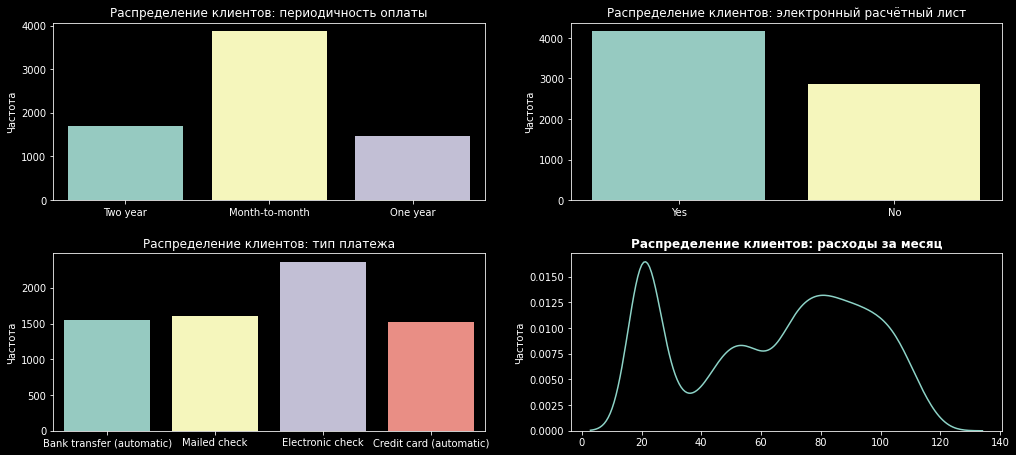

In [13]:
plt.figure(figsize=(17, 16))
plt.subplots_adjust(hspace=0.3) # Отступы

pylab.subplot(4, 2, 1)
type_order = df_contract['Type'].unique()
sns.countplot(data=df_contract, x='Type', order=type_order)
plt.title('Распределение клиентов: периодичность оплаты')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 2)
type_order = df_contract['PaperlessBilling'].unique()
sns.countplot(data=df_contract, x='PaperlessBilling', order=type_order)
plt.title('Распределение клиентов: электронный расчётный лист')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 3)
type_order = df_contract['PaymentMethod'].unique()
sns.countplot(data=df_contract, x='PaymentMethod', order=type_order)
plt.title('Распределение клиентов: тип платежа')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 4)
sns.kdeplot(df_contract['MonthlyCharges'])
plt.ylabel('Частота')
plt.xlabel('')
plt.title('Распределение клиентов: расходы за месяц', fontweight='bold', fontsize=12)

plt.show()

По визуализированным графикам мы можем сделать следующие выводы:
- `Периодиченость оплаты` - в `55%` случаев у пользователей ежемесячная оплата, оплаты раз в год и раз в два года встречаются одинаково часто (около `20%` случаев каждый).
- `Электонный расчетный лист` - пользователи чаще пользуются электронным расчетным листом (около `57%` случаев), однако разница несущественна, поскольку пользователей, которые не пользуются таким расчетным листом, тоже достаточно много.
- `Тип платежа` - в данной популяции преобладает `Mailed check` - более `2 000` из `7 000` или `35%`, однако остальных видов платежей также много, их примерно одинаковое количестно в районе `1 500` или в `20%` случае каждый.
- `Расходы за месяц` - в `23%` случаев не достигают `30 ед.`, однако в `46%` всей популяции ежемесячные расходы пользователей составляют `70-120 ед.`. Наиболее редко встречаются расходы `30-40 ед.` и `110-120 ед.`.

### Таблица `telecom.personal`

Загрузим также данную таблицу, посмотрим информацию о ней и визуализируем распределения признаков.

In [14]:
query = '''
select *
from telecom.personal
'''

df_personal = pd.DataFrame(engine.connect().execute(text(query)))

new_columns = ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']
df_personal.columns = new_columns

df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Таблица содержит `7 043` записи и не содержит пропусков.

In [15]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Колонка `SeniorCitizen` содержит цифровые данные, посмотрим, какие значения там хранятся.

In [16]:
df_personal['SeniorCitizen'].unique()

array([0, 1])

Мы убедились в том, что колонка содержит значения `0/1` или `Нет/Да`. Для целей дальнейшего анализа переведем данные значения в `Yes/No`.

In [17]:
df_personal['SeniorCitizen'].replace({0: 'No', 1: 'Yes'}, inplace=True)
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,No,Yes,No
1,5575-GNVDE,Male,No,No,No
2,3668-QPYBK,Male,No,No,No
3,7795-CFOCW,Male,No,No,No
4,9237-HQITU,Female,No,No,No


Построим графики для анализа информации.

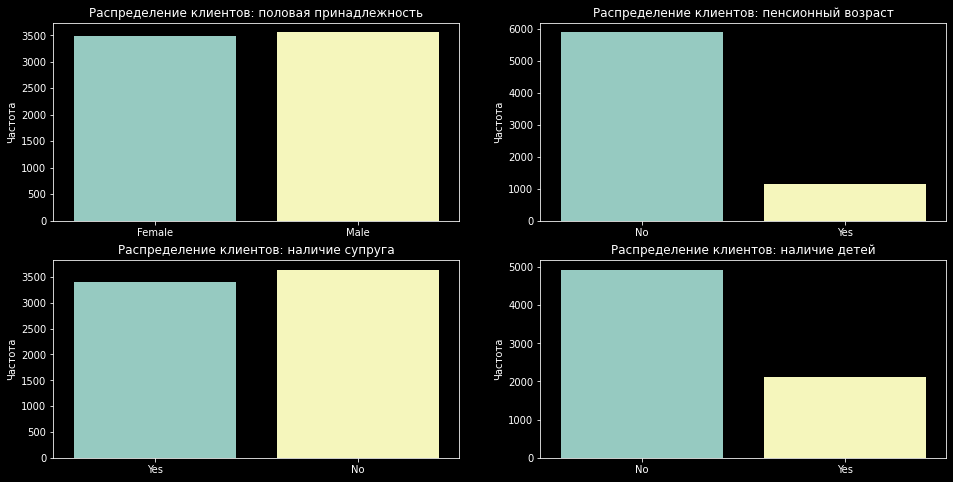

In [18]:
# Построение гистограммы
plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2) # Отступы

# 1 строка, 2 колонки, 1-ый график
pylab.subplot(2, 2, 1)
type_order = df_personal['gender'].unique()
sns.countplot(data=df_personal, x='gender', order=type_order)
plt.title('Распределение клиентов: половая принадлежность')
plt.ylabel('Частота')
plt.xlabel('')

# 1 строка, 2 колонки, 2-ый график
pylab.subplot(2, 2, 2)
type_order = df_personal['SeniorCitizen'].unique()
sns.countplot(data=df_personal, x='SeniorCitizen', order=type_order)
plt.title('Распределение клиентов: пенсионный возраст')
plt.ylabel('Частота')
plt.xlabel('')


# 2 строка, 2 колонки, 1-ый график
pylab.subplot(2, 2, 3)
type_order = df_personal['Partner'].unique()
sns.countplot(data=df_personal, x='Partner', order=type_order)
plt.title('Распределение клиентов: наличие супруга')
plt.ylabel('Частота')
plt.xlabel('')

# 2 строка, 2 колонки, 2-ый график
pylab.subplot(2, 2, 4)
type_order = df_personal['Dependents'].unique()
sns.countplot(data=df_personal, x='Dependents', order=type_order)
plt.title('Распределение клиентов: наличие детей')
plt.ylabel('Частота')
plt.xlabel('')

plt.show()

Согласно визуализации мы можем сделать следующие выводы:
- `Пол` - женский и мужской пол в датасете поставляет примерно одинаковое соотношение.
- `Пенсионный возраст` - пользователей пенсионного возраста не более `15%` от всей популяции, подавляющее большинство пользователей не являются пенсионерами.
- `Наличие супруга` - мы также можем наблюдать одинаковое соотношение пользователей с супругом и без.
- `Наличие детей` - почти `70%` всех пользователей не имеют детей.

### Таблица `telecom.internet`

Также произведем загрузку таблицы, предварительный анализ содржимого и визуализацию.

In [19]:
query = '''
select *
from telecom.internet
'''

df_internet = pd.DataFrame(engine.connect().execute(text(query)))

df_internet.columns = df_internet.iloc[0]  # переименование названий колонок
df_internet = df_internet[1:].reset_index(drop=True)  # удаление первой строки и сброс индекса
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Таблица содержит `5 517` записей, что примерно на `20%` меньше первых двух таблиц. Вероянее всего, в ней отсутствуют данные по части пользователей. рассмотрим этот вопрос далее, а пока проанализируем текущую таблицу.

In [20]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


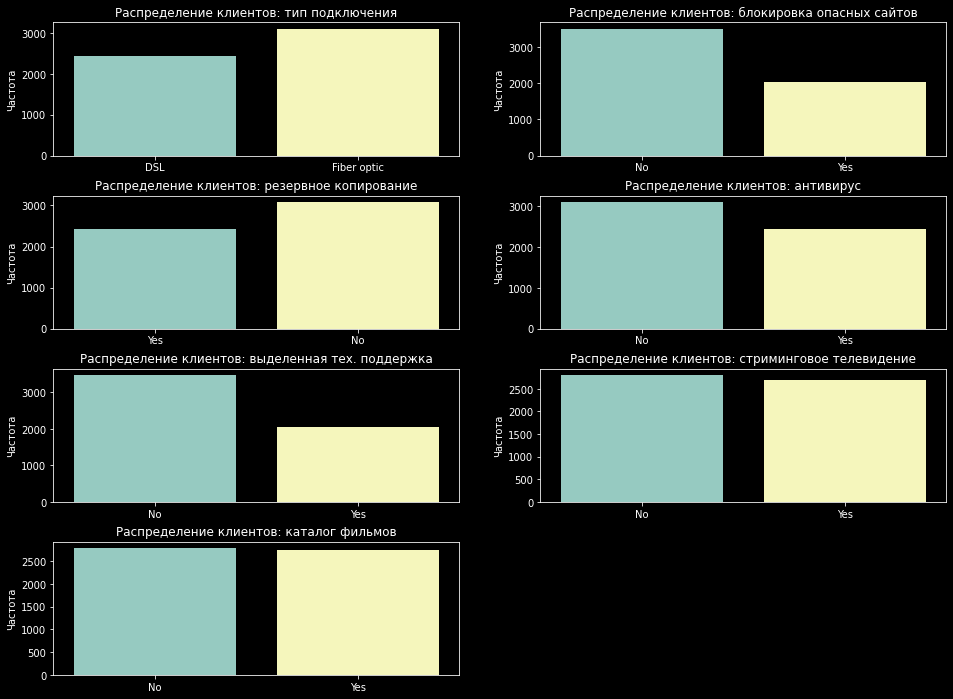

In [21]:
# Построение гистограммы
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.3) # Отступы

pylab.subplot(4, 2, 1)
type_order = df_internet['InternetService'].unique()
sns.countplot(data=df_internet, x='InternetService', order=type_order)
plt.title('Распределение клиентов: тип подключения')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 2)
type_order = df_internet['OnlineSecurity'].unique()
sns.countplot(data=df_internet, x='OnlineSecurity', order=type_order)
plt.title('Распределение клиентов: блокировка опасных сайтов')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 3)
type_order = df_internet['OnlineBackup'].unique()
sns.countplot(data=df_internet, x='OnlineBackup', order=type_order)
plt.title('Распределение клиентов: резервное копирование')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 4)
type_order = df_internet['DeviceProtection'].unique()
sns.countplot(data=df_internet, x='DeviceProtection', order=type_order)
plt.title('Распределение клиентов: антивирус')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 5)
type_order = df_internet['TechSupport'].unique()
sns.countplot(data=df_internet, x='TechSupport', order=type_order)
plt.title('Распределение клиентов: выделенная тех. поддержка')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 6)
type_order = df_internet['StreamingTV'].unique()
sns.countplot(data=df_internet, x='StreamingTV', order=type_order)
plt.title('Распределение клиентов: стриминговое телевидение')
plt.ylabel('Частота')
plt.xlabel('')

pylab.subplot(4, 2, 7)
type_order = df_internet['StreamingMovies'].unique()
sns.countplot(data=df_internet, x='StreamingMovies', order=type_order)
plt.title('Распределение клиентов: каталог фильмов')
plt.ylabel('Частота')
plt.xlabel('')

plt.show()

Согласно визуализации мы видим следующее:
- `Тип поключения` - имеются только два вида подключения: `DSL` и `Fiber optic`, последний используется в `55%` случаев.
- `Блокировка опасных сайтов` - в `60%` случаев пользователи не пользуются данной услугой.
- `Резервное копирование` - в `55%` случаев отсутствует.
- `Антивирус` - в `55%` случаев пользователи не используют эту услугу.
- `Выделенная линия тех. поддержки` - более `60%` пользователей не подключили данную услугу.
- `стриминговое телевидение` - в данной популяции пользователей с такив ТВ и без него примерно одинаковое соотношение.
- `Каталог фильмов` - ситуация аналогичная, это может быть связано с тем, что пользователи по умолчанию подключают себе вторую услугу при наличии стримингового ТВ.

### Таблица `telecom.phone`

Проделаем все то же самое с последней таблицей.

In [22]:
query = '''
select *
from telecom.phone
'''

df_phone = pd.DataFrame(engine.connect().execute(text(query)))

df_phone.columns = df_phone.iloc[0]  # переименование названий колонок
df_phone = df_phone[1:].reset_index(drop=True)  # удаление первой строки и сброс индекса
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Таблица имеет `6 361` строку, что примерно на `10%` меньше таблицы с договорами. Утчем это на этапе объединения всех таблиц в один датасет. Пропуски отсутствуют.

In [23]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


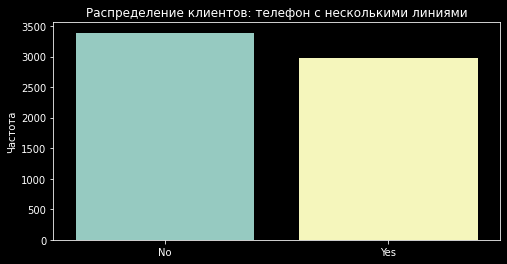

In [24]:
# Построение гистограммы
plt.figure(figsize=(8, 4))
type_order = df_phone['MultipleLines'].unique()
sns.countplot(data=df_phone, x='MultipleLines', order=type_order)
plt.title('Распределение клиентов: телефон с несколькими линиями')
plt.ylabel('Частота')
plt.xlabel('')
plt.show()

Согласно визуализации примерно одинаковое количество пользователей имеют подключение телефона к нескольким линиям одновременно, однако чаще встречается подключение к одной линии (около `54%` случаев).

### Объединная таблица

Объединим таблицы для дальнейшего анализа и изпользования в обучении. В таблицах `df_internet` и `df_phone` содержится меньшее количество информации о клиентах, методом эксперимента было произведено объединение всех таблиц методом `inner` и изучены результаты обучения - модели нехватило инфомации для предсказания оттока клиентов по метрике качества POC-AUC (должно быть не менее `85` согласно поставленной задаче). Поэтому мы объединяем только таблицы `df_contract` и `df_personal` методом `inner` (далее проверим на наличие в `customerID` значений `Null` и дублей), а таблицы `df_internet` и `df_phone` соединим методом `left`, поскольку у нас не может быть пользователей больше, чем в первых двух таблицах, посколько они основные по пользователям.

In [25]:
merged_df = pd.merge(df_contract, df_personal, on='customerID', how='outer')
merged_df = pd.merge(merged_df, df_internet, on='customerID', how='outer')
merged_df = pd.merge(merged_df, df_phone, on='customerID', how='outer')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   object 
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Проверим итоговую таблицу на наличие дублей клиентов.

In [26]:
duplicates = merged_df.duplicated(subset=['customerID'])
if duplicates.any():
    print('(!) Обнаружены дубликаты по customerID.')
else:
    print('Дубликаты по customerID не обнаружены.')

Дубликаты по customerID не обнаружены.


Сразу добавим дополнительные колонки для анализа: `BeginDateMonth` и `EndDateMonth`, выделим целевой признак закрытых договоров.

В колонках, означающих дополнительные услуги, имеются пропуски из-за соединения методом `outer`. Вероятно, это произошло из-за того, что такие клиенты просто не пользуются пакетом услуг, а не услугой в пределах пакета - поэтому нужна новая категория `No info`.

In [27]:
merged_df['BeginDateMonth'] = pd.to_datetime(merged_df['BeginDate']).dt.to_period('M')
merged_df['EndDateMonth'] = pd.to_datetime(merged_df['EndDate']).dt.to_period('M')
merged_df = merged_df[merged_df['BeginDate'].notnull()].reset_index(drop=True)

Выделим целевой признак для определения закрытия договора наосновании колонки `EndDate`.

In [28]:
merged_df['Closed'] = np.where(merged_df['EndDate'].isnull(), 0, 1) # Выделение целевого признака

Определим колонки с пустыми значениями и заполним их `No info` для дальнейшей работы. Также добавим новый признак `Count_Yes`, который посчитает, сколькими услугами пользовался клиент.

In [29]:
columns_to_fill = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                   'StreamingMovies', 'MultipleLines']
merged_df[columns_to_fill] = merged_df[columns_to_fill].fillna('No info')
merged_df['Count_Yes'] = (merged_df[['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'MultipleLines']] == 'Yes').sum(axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   customerID        7043 non-null   object   
 1   BeginDate         7043 non-null   object   
 2   EndDate           1869 non-null   object   
 3   Type              7043 non-null   object   
 4   PaperlessBilling  7043 non-null   object   
 5   PaymentMethod     7043 non-null   object   
 6   MonthlyCharges    7043 non-null   float64  
 7   TotalCharges      7043 non-null   float64  
 8   gender            7043 non-null   object   
 9   SeniorCitizen     7043 non-null   object   
 10  Partner           7043 non-null   object   
 11  Dependents        7043 non-null   object   
 12  InternetService   7043 non-null   object   
 13  OnlineSecurity    7043 non-null   object   
 14  OnlineBackup      7043 non-null   object   
 15  DeviceProtection  7043 non-null   object   
 16  TechSu

Теперь мы можем визуализировать итоговые данные и посмотреть, как они изменились. Также для показательности добавим визуализацию закрытых договоров по каждому признаку.

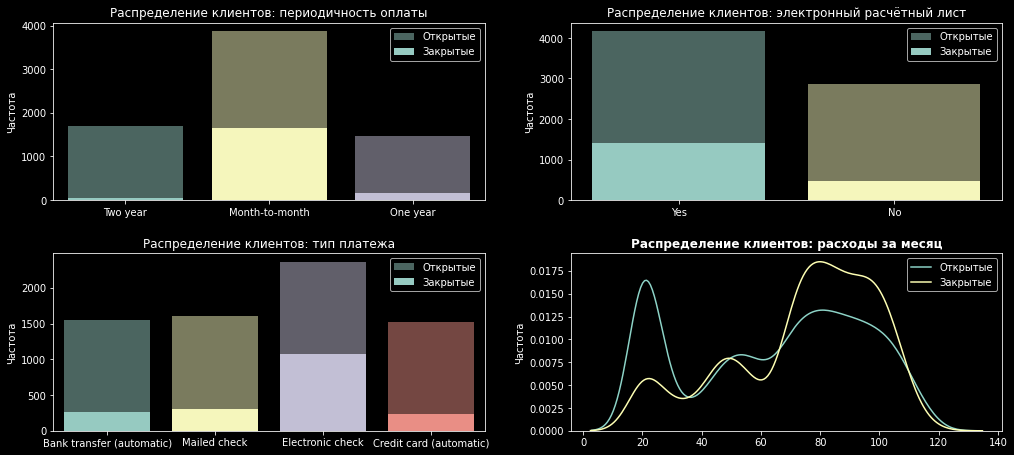

In [30]:
plt.figure(figsize=(17, 16))
plt.subplots_adjust(hspace=0.3) # Отступы

pylab.subplot(4, 2, 1)
type_order = merged_df['Type'].unique()
sns.countplot(data=merged_df, x='Type', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='Type', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: периодичность оплаты')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 2)
type_order = merged_df['PaperlessBilling'].unique()
sns.countplot(data=merged_df, x='PaperlessBilling', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='PaperlessBilling', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: электронный расчётный лист')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 3)
type_order = merged_df['PaymentMethod'].unique()
sns.countplot(data=merged_df, x='PaymentMethod', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='PaymentMethod', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: тип платежа')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 4)
sns.kdeplot(merged_df['MonthlyCharges'], label='Открытые')
sns.kdeplot(merged_df.loc[merged_df['Closed'] == 1, 'MonthlyCharges'], label='Закрытые')
plt.ylabel('Частота')
plt.xlabel('')
plt.title('Распределение клиентов: расходы за месяц', fontweight='bold', fontsize=12)
plt.legend()

plt.show()

По визуализированным графикам мы можем сделать следующие выводы:
- `Периодиченость оплаты` - в `55%` случаев у пользователей остается ежемесячная оплата, оплаты раз в год и раз в два года встречаются одинаково часто (около `20%` случаев каждый). При этом доля закрытых договоров при ежемесячной оплате достигает `40%`, а у остальных видом незначительна.
- `Электонный расчетный лист` - пользователи также чаще пользуются электронным расчетным листом (около `57%` случаев), однако разница несущественна, поскольку пользователей, которые не пользуются таким расчетным листом, тоже достаточно много. А вот доля закрытых договоров в первом случае достигает порядка `35%`, в то время как во втором примерно в два раза ниже - `17%`.
- `Тип платежа` - в данной популяции продолжает преобладать `Electronic check` - около `2 500` из `7 000` или `35%`, остальных видов платежей также много, их примерно одинаковое количестно в районе `1 500` или в `20%` случае каждый. С точки зрения закрытых договоров `Electronic check` имеет самую большую долю - `40%`, при этом у остальных видом наблюдается доля не более `17%`.
- `Расходы за месяц` - согласно графику мы четко видим, что при ежемесячной оплате `70-120 ед.` количество закрытых значительно увеличиваются.

Таким образом мы можем предварительно охарактеризовать пользователя, который с наибольшей вероятностью закроет договор:
- Ежемесячная оплата
- Электронный расчетный лист
- Тип платежа `Electronic check`
- Ежемесячные расходы `70-120 ед.`

Продолжим анализ.

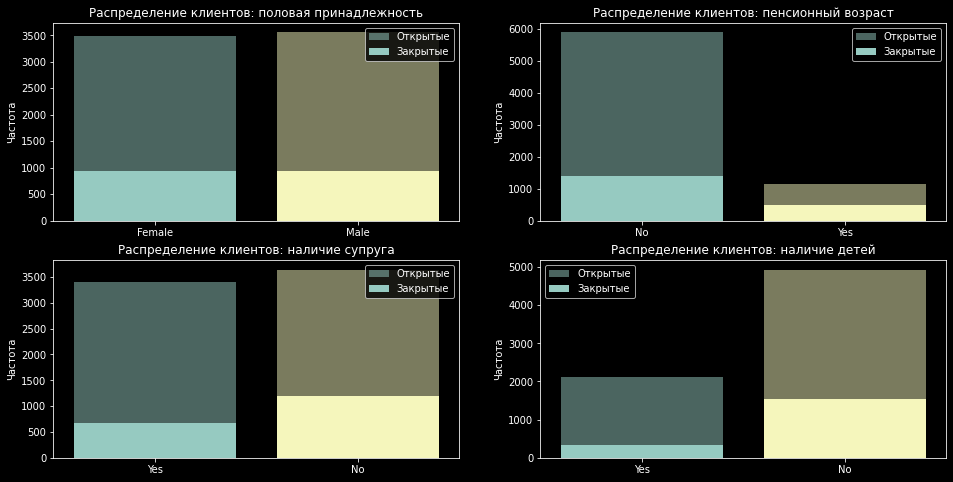

In [31]:
# Построение гистограммы
plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.2) # Отступы

# 1 строка, 2 колонки, 1-ый график
pylab.subplot(2, 2, 1)
type_order = merged_df['gender'].unique()
sns.countplot(data=merged_df, x='gender', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='gender', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: половая принадлежность')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

# 1 строка, 2 колонки, 2-ый график
pylab.subplot(2, 2, 2)
type_order = merged_df['SeniorCitizen'].unique()
sns.countplot(data=merged_df, x='SeniorCitizen', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='SeniorCitizen', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: пенсионный возраст')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()


# 2 строка, 2 колонки, 1-ый график
pylab.subplot(2, 2, 3)
type_order = merged_df['Partner'].unique()
sns.countplot(data=merged_df, x='Partner', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='Partner', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: наличие супруга')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

# 2 строка, 2 колонки, 2-ый график
pylab.subplot(2, 2, 4)
type_order = merged_df['Dependents'].unique()
sns.countplot(data=merged_df, x='Dependents', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='Dependents', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: наличие детей')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

plt.show()

Согласно визуализации мы можем сделать следующие выводы:
- `Пол` - женский и мужской пол в датасете также поставляет примерно одинаковое соотношение, то же можно сказать и о закрытых договорах, которые составлят не более `30%` в каждой популяции.
- `Пенсионный возраст` - пользователей пенсионного возраста также не более `15%` от всей популяции, подавляющее большинство пользователей не являются пенсионерами. Но вот соотношение закрытых договоров показывает, что таких больше именно у пользователей пенсионного возраста - почти `50%`, в то время как у более молодых пользователей такая доля составляет примерно `25%`.
- `Наличие супруга` - мы также можем наблюдать одинаковое соотношение пользователей с супругом и без, здесь тоже без изменений. Что интересно - при отсутствии супруга повышается доля закрывающих договоры - `37%`, а у людей с супругами доля в два раза меньше - `20%`.
- `Наличие детей` - почти `70%` всех пользователей не имеют детей. При этом `32%` закрыли договоры. А вот пользователи с детьми закрывают договоры в два раза реже - в `15%` случев.

Дополним портрет потенциального к потере пользователя:
- Любого пола
- Не относится к перисионному возрасту
- Вероятнее всего не имеет супруга
- Не имеет детей

Для дальнейших данных ранее мы заполнили пропуски по отсутствующим пользователям значением `No`, поскольку, вероятно, данные в БД не хранились, поскольку клиенты не пользовались ни одной услугой. Посмотрим на изменения в статистике.

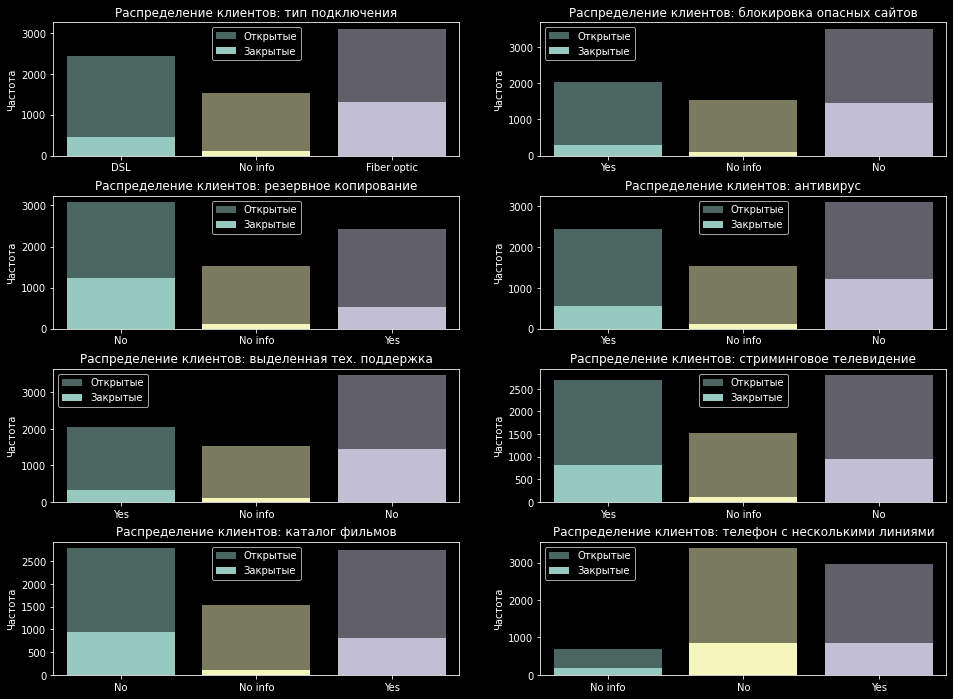

In [32]:
# Построение гистограммы
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.3) # Отступы

pylab.subplot(4, 2, 1)
type_order = merged_df['InternetService'].unique()
sns.countplot(data=merged_df, x='InternetService', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='InternetService', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: тип подключения')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 2)
type_order = merged_df['OnlineSecurity'].unique()
sns.countplot(data=merged_df, x='OnlineSecurity', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='OnlineSecurity', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: блокировка опасных сайтов')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 3)
type_order = merged_df['OnlineBackup'].unique()
sns.countplot(data=merged_df, x='OnlineBackup', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='OnlineBackup', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: резервное копирование')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 4)
type_order = merged_df['DeviceProtection'].unique()
sns.countplot(data=merged_df, x='DeviceProtection', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='DeviceProtection', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: антивирус')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 5)
type_order = merged_df['TechSupport'].unique()
sns.countplot(data=merged_df, x='TechSupport', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='TechSupport', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: выделенная тех. поддержка')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 6)
type_order = merged_df['StreamingTV'].unique()
sns.countplot(data=merged_df, x='StreamingTV', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='StreamingTV', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: стриминговое телевидение')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 7)
type_order = merged_df['StreamingMovies'].unique()
sns.countplot(data=merged_df, x='StreamingMovies', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='StreamingMovies', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: каталог фильмов')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(4, 2, 8)
type_order = merged_df['MultipleLines'].unique()
sns.countplot(data=merged_df, x='MultipleLines', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='MultipleLines', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: телефон с несколькими линиями')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

plt.show()

Мы видим, что у нас появляется новое значение `No info` - эта информация нам не известна, используем ее далее при обучении как дополнительную категорию.
Согласно визуализации мы видим следующее:
- `Тип поключения` - По имеющимся видам подключений `DSL` и `Fiber optic` доли распределились следующим образом: `Fiber optic` используется в `40%` случаев с долей закрытия `40%`, `DSL` в `35%` случаев с долей закрытия `20%`. `20%` популяции - новая категория, доля закрытия несущественна.
- `Блокировка опасных сайтов` - доля клиентов, которые не пользуются данной услугой стала `52%`, доля закрытых договов `42%`. Новая категория неизвестных составила `21%`, доля закрытых несущественна.
- `Резервное копирование` - отсутствие услуги уменьшилось с `55%` до `42%`, доля закрытых у таких составляет порядка `40%` против `20%` у тех, кто услугу использует. `20%` - новая категория, доля закрытых договоров несущественна.
- `Антивирус` - аналогичная ситуация с уменьшением доли с `55%` до `42%` пользователей, которые не используют эту услугу. Доля закрытых договоров составляет `236%` и `20%` соответственно. Новая категория - `20%` клиентов, доля закрытых несущественна.
- `Выделенная линия тех. поддержки` - доля пользователей без услуги уменьшилась с `60%` до `48%`, закрытые договоры составили `44%` против `10%` тех, кто пользуется услугой. Доля новой категории составила `24%`, доля закрытых договоров несущественна.
- `Стриминговое телевидение` - в данной популяции доли пользователей с услугой и без услуги уменьшились с `50%` до `37%`. А вот количество закрытых договоров примерно одинаковое по известным - `38%`. Новая категория составила `21%`, доля закрытых несущественна.
- `Каталог фильмов` - ситуация аналогичная, это может быть связано с тем, что пользователи по умолчанию подключают себе вторую услугу при наличии стримингового ТВ.
- `Телефон с несколькими линиями` - количество пользователей с одной линией упало с `54%` до `47%`, при этом доля закрытых договоров составляет `25%` против `33%` тех, кто имеет несколько линий. Новая категория составила порядка `11%`, треть из них закрылись.

Таким образом портрет потенциального пользователя к потере пополняется следующими характеристиками:
- Тип подключения `Fiber optic`
- Блокировка опасных сайтов отсутствует
- Резервное копирование отсутствует
- Антивирус отсутствует
- Выделенная линия тех. поддержки не используется
- Стриминговое телевидение и каталог фильмов могут быть как подключены, так и не подключены
- Может иметь как одну, так и несколько линий

По последним трем параметрам разницы несущественна для каких-либо выводов в пользу закрытия либо сохранения договора.

Добавим два дополнительных параметра и рассматорим соотношения пользователей, которые подключили себе все услуги, либо не пользуются ни одной.

In [33]:
merged_df['AllServices'] = np.where(
    (merged_df['OnlineSecurity'] == 'Yes') &
    (merged_df['OnlineBackup'] == 'Yes') &
    (merged_df['DeviceProtection'] == 'Yes') &
    (merged_df['TechSupport'] == 'Yes') &
    (merged_df['StreamingTV'] == 'Yes') &
    (merged_df['StreamingMovies'] == 'Yes'),
    'Yes',
    'No'
)

merged_df['NoServices'] = np.where(
    (merged_df['OnlineSecurity'] == 'No') &
    (merged_df['OnlineBackup'] == 'No') &
    (merged_df['DeviceProtection'] == 'No') &
    (merged_df['TechSupport'] == 'No') &
    (merged_df['StreamingTV'] == 'No') &
    (merged_df['StreamingMovies'] == 'No'),
    'Yes',
    'No'
)

df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


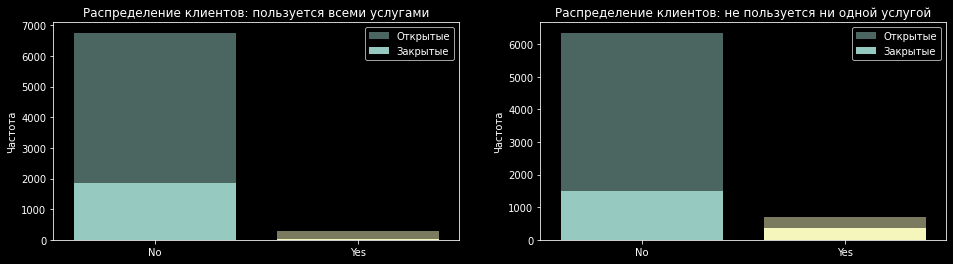

In [34]:
# Построение гистограммы
plt.figure(figsize=(16, 4))

pylab.subplot(1, 2, 1)
type_order = merged_df['AllServices'].unique()
sns.countplot(data=merged_df, x='AllServices', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='AllServices', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: пользуется всеми услугами')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

pylab.subplot(1, 2, 2)
type_order = merged_df['NoServices'].unique()
sns.countplot(data=merged_df, x='NoServices', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='NoServices', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: не пользуется ни одной услугой')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()

plt.show()

По результатам визуализации можно сделать следующие выводы:
- `Пользуются всеми услугами` - таких клиентов крайне мало, порядка `3%`, по таким даже не видно доли закрытых договоров, которая также крайне мала.
- `Не пользуются ни одной услугой` - а вот таких клиентов порядка `10%`, из них около `50%` закрыли договоры.

Добавим харатеристики к портрету:
- Вероятнее всего пользуется не всеми услугами, но частью из них.

Теперь рассмотрим поведение пользователей на фоне временной шкалы.

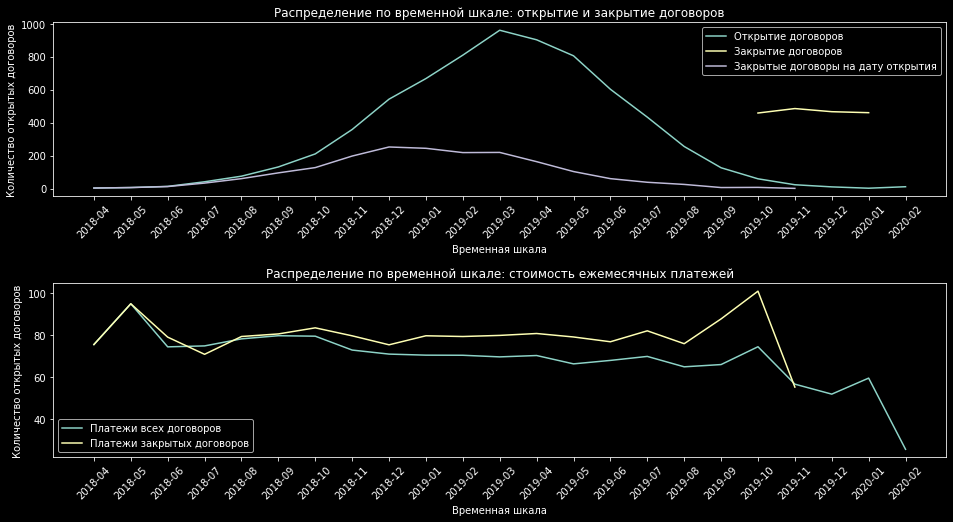

In [35]:
plt.figure(figsize=(16, 8))

pylab.subplot(2, 1, 1)
begin_date_grouped = merged_df.groupby('BeginDateMonth').size().reset_index(name='Open').sort_values(by='BeginDateMonth').set_index('BeginDateMonth')
end_date_grouped = merged_df.groupby('EndDateMonth').size().reset_index(name='Close').sort_values(by='EndDateMonth').set_index('EndDateMonth')
begin_date_grouped_closed = merged_df.query('Closed == 1').groupby('BeginDateMonth').size().reset_index(name='Count').sort_values(by='BeginDateMonth').set_index('BeginDateMonth')
date_grouped = begin_date_grouped.join(end_date_grouped)
date_grouped = date_grouped.join(begin_date_grouped_closed)

date_grouped.index = date_grouped.index.strftime('%Y-%m')
plt.plot(date_grouped.index, date_grouped['Open'], label='Открытие договоров')
plt.plot(date_grouped.index, date_grouped['Close'], label='Закрытие договоров')
plt.plot(date_grouped.index, date_grouped['Count'], label='Закрытые договоры на дату открытия')

plt.title('Распределение по временной шкале: открытие и закрытие договоров')
plt.xlabel('Временная шкала')
plt.ylabel('Количество открытых договоров')
plt.xticks(rotation=45)
plt.legend()

pylab.subplot(2, 1, 2)
monthly_charges_grouped = merged_df.groupby('BeginDateMonth')['MonthlyCharges'].median().reset_index(name='Charges').sort_values(by='BeginDateMonth').set_index('BeginDateMonth')
monthly_charges_grouped_closed = merged_df.query('Closed == 1').groupby('BeginDateMonth')['MonthlyCharges'].median().reset_index(name='Count').sort_values(by='BeginDateMonth').set_index('BeginDateMonth')
date_grouped = monthly_charges_grouped.join(monthly_charges_grouped_closed)

date_grouped.index = monthly_charges_grouped.index.strftime('%Y-%m')
plt.plot(date_grouped.index, date_grouped['Charges'], label='Платежи всех договоров')
plt.plot(date_grouped.index, date_grouped['Count'], label='Платежи закрытых договоров')

plt.title('Распределение по временной шкале: стоимость ежемесячных платежей')
plt.xlabel('Временная шкала')
plt.ylabel('Количество открытых договоров')
plt.xticks(rotation=45)
plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()

Согласно графику мы видим, следующее:
- Активный период открытия новых договоров приходится на `Ноябрь 2018` - `Июль 2019`, самое большое количество открытых договоров пришлось на `Февраль - Май 2019 года`.
- При этом закрытие договоров происходило в период `Октябрь 2019` - `Январь 2020`.
- Чаще всего закрывались договоры, открытые в `Октябре 2018` - `Апреле 2019`.
- Стоимость закрытых договоров чаще была выше стоимости открытых договоров.

К портрету потенциального к потере клиента можно добавить следующее:
- Договор был открыт в период `Октябрь 2019` - `Январь 2020`
- Стоимость ежемесячных платежей выше среднего по портфелю клиентов

Добавим признак длительности закрытых договоров и проанализируем показатель.

In [36]:
merged_df['Term'] = (merged_df['EndDate'] - merged_df['BeginDate']).dt.days
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   customerID        7043 non-null   object   
 1   BeginDate         7043 non-null   object   
 2   EndDate           1869 non-null   object   
 3   Type              7043 non-null   object   
 4   PaperlessBilling  7043 non-null   object   
 5   PaymentMethod     7043 non-null   object   
 6   MonthlyCharges    7043 non-null   float64  
 7   TotalCharges      7043 non-null   float64  
 8   gender            7043 non-null   object   
 9   SeniorCitizen     7043 non-null   object   
 10  Partner           7043 non-null   object   
 11  Dependents        7043 non-null   object   
 12  InternetService   7043 non-null   object   
 13  OnlineSecurity    7043 non-null   object   
 14  OnlineBackup      7043 non-null   object   
 15  DeviceProtection  7043 non-null   object   
 16  TechSu

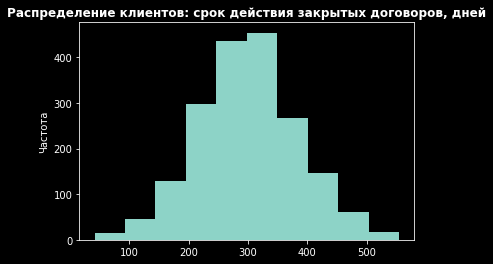

In [37]:
plt.hist(merged_df['Term'])
plt.ylabel('Частота')
plt.title('Распределение клиентов: срок действия закрытых договоров, дней', fontweight='bold', fontsize=12)
plt.show()

Чаще всего закрытых договор имел срок жизни `200-400` дней. Это наблюдение также можно добавить к нашему портрету.

Рассмотрим корреляцию признаков к факту закрытия договора.

Теперь дозаполним признак продолжительности действия договора в днях для открытых для дальнейшего использования в обучении - разницей между датой начала и датой актуальности данных 01.02.2020.

In [38]:
merged_df['Term'] = merged_df['Term'].fillna((datetime(2020, 2, 1).date() - merged_df['BeginDate']).dt.days)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   customerID        7043 non-null   object   
 1   BeginDate         7043 non-null   object   
 2   EndDate           1869 non-null   object   
 3   Type              7043 non-null   object   
 4   PaperlessBilling  7043 non-null   object   
 5   PaymentMethod     7043 non-null   object   
 6   MonthlyCharges    7043 non-null   float64  
 7   TotalCharges      7043 non-null   float64  
 8   gender            7043 non-null   object   
 9   SeniorCitizen     7043 non-null   object   
 10  Partner           7043 non-null   object   
 11  Dependents        7043 non-null   object   
 12  InternetService   7043 non-null   object   
 13  OnlineSecurity    7043 non-null   object   
 14  OnlineBackup      7043 non-null   object   
 15  DeviceProtection  7043 non-null   object   
 16  TechSu

In [39]:
def charges(row):
  if row['Type'] == 'Month-to-month':
    return row['TotalCharges'] - (row['Term'] / 30 * row['MonthlyCharges'])
  elif row['Type'] == 'One year':
    return row['TotalCharges'] - (row['Term'] / 30 * row['MonthlyCharges']) / 12
  elif row['Type'] == 'Two year':
    return row['TotalCharges'] - (row['Term'] / 30 * row['MonthlyCharges']) / 24

merged_df['MissPaid'] = merged_df.apply(charges, axis=1)
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,StreamingMovies,MultipleLines,BeginDateMonth,EndDateMonth,Closed,Count_Yes,AllServices,NoServices,Term,MissPaid
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,...,No,No info,2020-02,NaT,0,4,No,No,0.0,52.550
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,20.25,Male,No,...,No info,No,2020-02,NaT,0,0,No,No,0.0,20.250
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,No,No,2018-08,2019-12,1,2,No,No,479.0,-751.655
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,80.85,Female,No,...,Yes,No,2020-02,NaT,0,5,No,No,0.0,80.850
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,...,No,No,2019-01,2019-11,1,0,No,Yes,279.0,-505.860


In [40]:
merged_df['MissPaid'] = merged_df.apply(lambda row: 'Yes' if row['MissPaid'] < 0 else 'No', axis=1)
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,StreamingMovies,MultipleLines,BeginDateMonth,EndDateMonth,Closed,Count_Yes,AllServices,NoServices,Term,MissPaid
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,No,...,No,No info,2020-02,NaT,0,4,No,No,0.0,No
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,20.25,Male,No,...,No info,No,2020-02,NaT,0,0,No,No,0.0,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,No,...,No,No,2018-08,2019-12,1,2,No,No,479.0,Yes
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,80.85,Female,No,...,Yes,No,2020-02,NaT,0,5,No,No,0.0,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,No,...,No,No,2019-01,2019-11,1,0,No,Yes,279.0,Yes


In [41]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'Term', 'Count_Yes']
phik_matrix = merged_df.drop(['customerID', 'EndDateMonth', 'BeginDate', 'EndDate'], axis=1).phik_matrix(
                                                                                        interval_cols=interval_cols)
phik_matrix

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,...,StreamingTV,StreamingMovies,MultipleLines,BeginDateMonth,Closed,Count_Yes,AllServices,NoServices,Term,MissPaid
Type,1.000000,0.106860,0.277462,0.388266,0.505287,0.000000,0.086231,0.179736,0.147680,0.505187,...,0.549564,0.553556,0.244410,0.212242,0.251639,0.456149,0.175966,0.167912,0.037860,0.321908
PaperlessBilling,0.106860,1.000000,0.370495,0.467783,0.205901,0.000000,0.242133,0.013218,0.172593,0.231438,...,0.204717,0.202241,0.099953,0.077042,0.295754,0.342467,0.004148,0.075502,0.050069,0.007804
PaymentMethod,0.277462,0.370495,1.000000,0.399536,0.350460,0.000000,0.292725,0.243008,0.224903,0.323886,...,0.284531,0.285525,0.174849,0.130472,0.449125,0.463011,0.205400,0.204522,0.000868,0.427157
MonthlyCharges,0.388266,0.467783,0.399536,1.000000,0.762960,0.009025,0.304691,0.203237,0.184213,0.918980,...,0.864642,0.863641,0.710101,0.117674,0.360038,0.781431,0.609953,0.716458,0.016415,0.362532
TotalCharges,0.505287,0.205901,0.350460,0.762960,1.000000,0.000000,0.148755,0.422402,0.114304,0.508171,...,0.567408,0.569270,0.493551,0.089129,0.279152,0.659380,0.683323,0.360747,0.010908,0.864231
gender,0.000000,0.000000,0.000000,0.009025,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304691,0.148755,0.000000,1.000000,0.016992,0.324576,0.160702,...,0.111714,0.113778,0.087925,0.057662,0.233432,0.181336,0.007452,0.087575,0.034522,0.000000
Partner,0.179736,0.013218,0.243008,0.203237,0.422402,0.000000,0.016992,1.000000,0.652122,0.000000,...,0.082251,0.077506,0.086249,0.073429,0.232930,0.303770,0.164551,0.221023,0.016432,0.446080
Dependents,0.147680,0.172593,0.224903,0.184213,0.114304,0.000000,0.324576,0.652122,1.000000,0.108463,...,0.088193,0.084684,0.011198,0.093992,0.253936,0.122552,0.075406,0.158628,0.035546,0.253726
InternetService,0.505187,0.231438,0.323886,0.918980,0.508171,0.000000,0.160702,0.000000,0.108463,1.000000,...,0.946713,0.946294,0.739808,0.175401,0.196202,0.634022,0.066740,0.104686,0.030204,0.009808


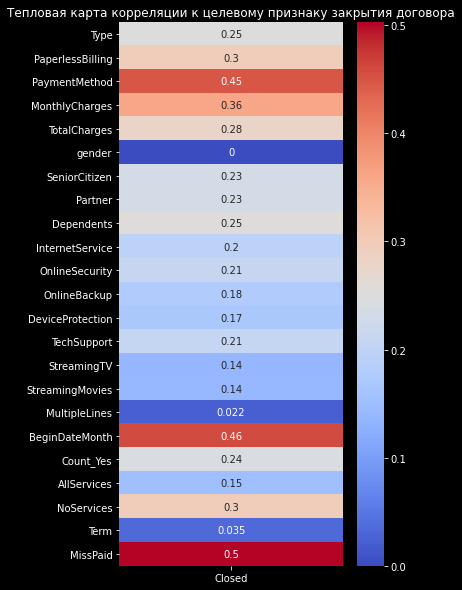

In [42]:
# Визуализация тепловой карты
plt.figure(figsize=(5, 10))
sns.heatmap(phik_matrix.drop('Closed', axis=0)[['Closed']], annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции к целевому признаку закрытия договора')
plt.show()

На данном этапе мы видим следующее:
1. Наибольшую корреляцию с целевым призаком закрытия договора имеют следующие признаки:
- `BeginDateMonth` - дата начала дейтсвия договора, однако в дальнейшем мы не будем использовать данный признак для обучения, т.к. перед нами не стоит задача временных рядов.
- `Overpayment` и `Underpayment` - суммы переплат и недоплат за период действия договора.
- `PaymentMethod` - тип платежа.
- `ExtraPaid` - переплаты.
2. Наименьшую корреляцию показывают `gender` (пол), `MultipleLines` (телефон подключен к нескольким линиям) и `Term` (срок действия договора).

### Портрет потенциально потерянного клиента

По результатам проведенного анализа мы можем описать вероятный портрет клиента, которого можем потерять:
- Ежемесячная оплата
- Электронный расчетный лист
- Тип платежа `Electronic check`
- Ежемесячные расходы `70-120 ед.`
- Любого пола
- Не относится к перисионному возрасту
- Вероятнее всего не имеет супруга
- Не имеет детей
- Тип подключения `Fiber optic`
- Блокировка опасных сайтов отсутствует
- Резервное копирование отсутствует
- Антивирус отсутствует
- Выделенная линия тех. поддержки не используется
- Стриминговое телевидение и каталог фильмов могут быть как подключены, так и не подключены
- Может иметь как одну, так и несколько линий
- Вероятнее всего пользуется не всеми услугами, но частью из них
- Договор был открыт в период `Октябрь 2019` - `Январь 2020`
- Стоимость ежемесячных платежей выше среднего по портфелю клиентов
- Срок жизни договора `200-400` дней.

Теперь мы можем приступить к подготовке данных к обучению.

### Подготовка данных для обучения

Еще раз посмотрим на имющиеся данные.

In [43]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   customerID        7043 non-null   object   
 1   BeginDate         7043 non-null   object   
 2   EndDate           1869 non-null   object   
 3   Type              7043 non-null   object   
 4   PaperlessBilling  7043 non-null   object   
 5   PaymentMethod     7043 non-null   object   
 6   MonthlyCharges    7043 non-null   float64  
 7   TotalCharges      7043 non-null   float64  
 8   gender            7043 non-null   object   
 9   SeniorCitizen     7043 non-null   object   
 10  Partner           7043 non-null   object   
 11  Dependents        7043 non-null   object   
 12  InternetService   7043 non-null   object   
 13  OnlineSecurity    7043 non-null   object   
 14  OnlineBackup      7043 non-null   object   
 15  DeviceProtection  7043 non-null   object   
 16  TechSu

Для дальнейшего обучения и воспроизводимости данных при выявлении важности признаков закодируем месяц заключения договора - единственный признак в формате даты, который мы будем использовать в дальнейшем.

Определим признаки, на которых будем тренировать и тестировать модели, а также целевой признак.

In [44]:
learning_columns = [
    #'customerID', # ID абонента - уникальный идентификатор, не имеет какого-либо влияния на прекращение договора
    #'BeginDate', # дата начала действия договора - непоказательный признак, далее мы будем использовать его производную BeginDateMonth
    #'EndDate', # дата окончания действия договора - признак, от которого был произведен целевой
    'Type', # тип оплаты: раз в год-два или ежемесячно
    'PaperlessBilling', # электронный расчётный лист
    'PaymentMethod', # тип платежа
    'MonthlyCharges', # расходы за месяц
    'TotalCharges', # общие расходы абонента
    'gender', # пол
    'SeniorCitizen', # является ли абонент пенсионером
    'Partner', # есть ли у абонента супруг или супруга
    'Dependents', # есть ли у абонента дети
    'InternetService', # тип подключения
    'OnlineSecurity', # блокировка опасных сайтов
    'OnlineBackup', # облачное хранилище файлов для резервного копирования данных
    'DeviceProtection', # антивирус
    'TechSupport', # выделенная линия технической поддержки
    'StreamingTV', # стриминговое телевидение
    'StreamingMovies', # каталог фильмов
    'MultipleLines', # подключение телефона к нескольким линиям одновременно
    #'BeginDateMonth', # месяц начала действия договора, используем вмето него признак Term
    #'EndDateMonth', # месяц окончания действия договора - имеет отношение к целевому признаку, убираем, чтобы избежать утечки
    ##'AllServices', # признак того, что у пользователя подключены все интернет-услуги
    'NoServices', # признак того, что у пользователя не подключено на одной интернет-услуги
    'Term',
    'Count_Yes',
    'MissPaid'
]

target_column = 'Closed'

Разделим популяцию на тренировочную и тестовую с помощью `train_test_split`.

In [45]:
features = merged_df[learning_columns]
target = merged_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25,
                                                    shuffle=True, 
                                                    random_state=RANDOM_STATE)

X_train_splited = X_train.reset_index(drop=True)
X_test_splited = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [46]:
X_train_splited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   gender            5282 non-null   object 
 6   SeniorCitizen     5282 non-null   object 
 7   Partner           5282 non-null   object 
 8   Dependents        5282 non-null   object 
 9   InternetService   5282 non-null   object 
 10  OnlineSecurity    5282 non-null   object 
 11  OnlineBackup      5282 non-null   object 
 12  DeviceProtection  5282 non-null   object 
 13  TechSupport       5282 non-null   object 
 14  StreamingTV       5282 non-null   object 
 15  StreamingMovies   5282 non-null   object 
 16  MultipleLines     5282 non-null   object 


### Кодирование и масштабирование признаков

Для кодирования и масштабирования признаков создадим единый `Pipeline`, в котором настроим кодировку категориальных признаков с помощью `OrdinalEncoder` и дальнейшее масштабирование всех признаков с помощью `StandardScaler`. `OrdinalEncoder` самостоятельно определяет и кодирует категориальные признаки.

Затем применим `Pipeline` ко всем выборкам.

In [47]:
cat_columns = X_train_splited.select_dtypes(include=['object']).columns.tolist()

pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())

])

X_train = pipeline.fit_transform(X_train_splited)
X_test = pipeline.transform(X_test_splited)

X_train

array([[-0.82553429,  0.82496059,  0.39943044, ..., -0.76075251,
         1.73268282, -0.5792449 ],
       [-0.82553429, -1.21217912, -1.46352019, ..., -0.49357381,
         0.7575064 , -0.5792449 ],
       [-0.82553429, -1.21217912,  0.39943044, ...,  0.58728547,
        -0.21767001, -0.5792449 ],
       ...,
       [ 1.57560674,  0.82496059, -0.53204488, ..., -0.0563723 ,
         0.2699182 , -0.5792449 ],
       [ 1.57560674, -1.21217912,  0.39943044, ..., -2.70387031,
         2.22027103, -0.5792449 ],
       [-0.82553429,  0.82496059, -1.46352019, ..., -0.28711754,
         0.7575064 , -0.5792449 ]])

Данные подготовлены, теперь можно приступать к обучению моделей.

## Обучение моделей

Для обучения рассмотрим три различные модели:
- Случайный лес `RandomForestClassifier`
- Бустинговую модель `CatBoostClassifier`
- Нейронную сеть с помощью `PyTorch`


Для фиксации результатов метрики качества `ROC-AUC` (по поставленной задаче) будем использовать отдельную переменную.

In [49]:
scores = []

### RandomForestClassifier

Подберем наиболее подходящие гипер-параметры с использованием кросс-валидации, дающие максимальную метрику качества.

In [50]:
# Создание модели случайного леса
model = RandomForestClassifier(random_state=RANDOM_STATE)

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

# Создание объекта GridSearchCV с метрикой roc_auc
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3)

# Обучение модели
grid_search.fit(X_train, y_train)

# Лучшие значения гиперпараметров
best_params_RandomForest = grid_search.best_params_
print('Лучшие значения гиперпараметров:', best_params_RandomForest)

# Вывод лучшего ROC-AUC на кросс-валидации
best_roc_auc = round(grid_search.best_score_,3)
print('Лучший ROC-AUC на кросс-валидации:', best_roc_auc)

scores.append(['RandomForestClassifier', best_roc_auc])

Лучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50}
Лучший ROC-AUC на кросс-валидации: 0.84


### CatBoostClassifier

Аналогично поступим с данной моделью, однако подбором гиперпараметров с использованием кросс-валидации займется встроенная функция `.grid_search()`.

У данной модели есть встроенный функционал кодировки категориальных признаков и масштабирования, поэтому определим такие признаки и укажем их для модели.

In [51]:
# Создание модели CatBoostClassifier
params = {
              'eval_metric': 'AUC',
              'iterations': 1000,
              'early_stopping_rounds': 100,
              'verbose': 100,
              'cat_features': cat_columns
             }

model = CatBoostClassifier(**params, random_state=RANDOM_STATE)

# Определение сетки гиперпараметров для поиска
param_grid = {
              'depth': [2, 4, 6, 8, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9],
              'learning_rate': [0.001, 0.01]
             }

grid_search_result = model.grid_search(param_grid,
                                       X = X_train_splited,
                                       y = y_train,
                                       cv = 3,
                                       plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7576995	best: 0.7576995 (0)	total: 53.6ms	remaining: 53.6s
100:	test: 0.7933285	best: 0.7933285 (100)	total: 401ms	remaining: 3.57s
200:	test: 0.8226630	best: 0.8236020 (185)	total: 746ms	remaining: 2.97s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8236020045
bestIteration = 185

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8236020	best: 0.8236020 (0)	total: 1.64s	remaining: 1m 20s
0:	test: 0.7576995	best: 0.7576995 (0)	total: 4.89ms	remaining: 4.89s
100:	test: 0.8246089	best: 0.8251358 (94)	total: 346ms	remaining: 3.08s
200:	test: 0.8287303	best: 0.8288240 (197)	total: 692ms	remaining: 2.75s
300:	test: 0.8315170	best: 0.8315170 (300)	total: 1.06s	remaining: 2.46s
400:	test: 0.8329688	best: 0.8331093 (397)	total: 1.46s	remaining: 2.19s
500:	test: 0.8340694	best: 0.8342895 (490)	total: 1.88s	remaining: 1.88s
600:	test: 0.8349194	best: 0.8349194 (600)	to

In [52]:
# Лучшие гиперпараметры
best_params_CatBoost = grid_search_result['params']
print('Лучшие параметры:', best_params_CatBoost)

# Лучшее значение метрики на кросс-валидации
best_score = round(max(grid_search_result['cv_results']['test-AUC-mean']),3)
print('Лучшее значение метрики ROC-AUC на кросс-валидации:', best_score)

scores.append(['CatBoostClassifier', best_score])

Лучшие параметры: {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Лучшее значение метрики ROC-AUC на кросс-валидации: 0.841


### PyTorch

Для использования `PyTorch` переведем тренировочные и валидационные данные в тензоры.

In [53]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

Настроим нейронную сеть. Используем несколько скрытых слоев с функцией акцивации `Sigmoid`.

In [54]:
n_in = X_train_tensor.shape[1]
n_hid_1 = 300
n_hid_2 = 200
n_hid_3 = 100
n_hid_4 = 50
n_out = 1
p = 0.

net = nn.Sequential(
        nn.Linear(n_in, n_hid_1), nn.Sigmoid(),
        nn.Linear(n_hid_1, n_hid_2), nn.Sigmoid(), nn.Dropout(p=p),
        nn.Linear(n_hid_2, n_hid_3), nn.Sigmoid(), nn.Dropout(p=p),
        nn.Linear(n_hid_3, n_hid_4), nn.Sigmoid(), nn.Dropout(p=p),
        nn.Linear(n_hid_4, n_out)
    )

Укажем функцию потерь, а также оптимизатор для задачи классификации. Обучим нашу нейросеть на `1 000` эпохах.

In [55]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0001)
num_epochs = 1000

# Определение k-fold Cross-Validation с разбиением на 3 корзины
kfold = KFold(n_splits=3)

auc_scores = []

# Выполнение кросс-валидации и оценка качества модели по метрике ROC-AUC
for train_indices, valid_indices in kfold.split(X_train_tensor):
    X_train_fold = X_train_tensor[train_indices]
    y_train_fold = y_train_tensor[train_indices]
    X_valid_fold = X_train_tensor[valid_indices]
    y_valid_fold = y_train_tensor[valid_indices]
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = net(X_train_fold)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

    net.eval()
    with torch.no_grad():
        predicted = torch.sigmoid(net(X_valid_fold)).numpy()
        
    roc_auc = roc_auc_score(y_valid_fold.numpy(), predicted)
    auc_scores.append(roc_auc)

# Вычисление ROC-AUC на валидационных данных
mean_auc = round(np.mean(auc_scores),3)
print('ROC-AUC на кросс-валидации:', mean_auc)

scores.append(['PyTorch', mean_auc])

ROC-AUC на кросс-валидации: 0.828


## Тестирование модели и демонстрация ее работы

Для начала выведем и визуализируем метрики качества `ROC-AUC` на валидации для каждой модели.

,Модель,ROC-AUC на кросс-валидации
0,RandomForestClassifier,0.840
1,CatBoostClassifier,0.841
2,PyTorch,0.828


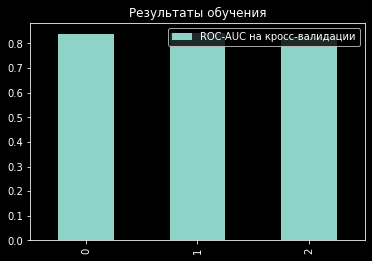

In [67]:
df_results = pd.DataFrame(scores, columns=['Модель', 'ROC-AUC на кросс-валидации'])
display(df_results)

df_results.plot(kind='bar')
plt.title('Результаты обучения')
plt.ylabel('')
plt.show()

Мы видим, что показатели заданной метики качества `ROC-AUC` примерно одинковое, однако у `PyTorch` не достигает поставленной задачи - `не менее 85`. Наибольший показатель с минимальным отрывой отражает `CatBoostClassifier`, используем данную модель для предсказания на тесте.

### Предсказание теста на лучшей модели

In [58]:
# Создание модели с лучшими гиперпараметрами
best_model = CatBoostClassifier(**params, **best_params_CatBoost, random_state=RANDOM_STATE)

# Обучение модели на полном тренировочном наборе данных
best_model.fit(X_train_splited, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test_splited)

y_pred_proba = best_model.predict_proba(X_test_splited)[:, 1]
auc = round(roc_auc_score(y_test, y_pred_proba),3)
print('Значение метрики ROC-AUC:', auc)

0:	total: 17.3ms	remaining: 17.3s
100:	total: 1.36s	remaining: 12.1s
200:	total: 2.65s	remaining: 10.5s
300:	total: 3.99s	remaining: 9.26s
400:	total: 5.25s	remaining: 7.83s
500:	total: 6.57s	remaining: 6.54s
600:	total: 7.88s	remaining: 5.23s
700:	total: 9.15s	remaining: 3.9s
800:	total: 10.6s	remaining: 2.63s
900:	total: 12.1s	remaining: 1.32s
999:	total: 13.6s	remaining: 0us
Значение метрики ROC-AUC: 0.853


Метрика качества на тестовых данных составила `0.88` - поставленная задача выполнена, `ROC-AUC` на тесте превышает необходимые `0.85`.

### Accuracy

Для понимания посмотрим на `Accuracy`.

In [59]:
best_threshold = None
best_accuracy = 0.0

for threshold in np.arange(0.1, 1.0, 0.1):
    predicted_labels = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, predicted_labels)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print('Лучший трешхолд:', round(best_threshold,2))
print('Лучший accuracy:', round(best_accuracy,2))

Лучший трешхолд: 0.6
Лучший accuracy: 0.81


Подобрав наилучший трешхолд мы получили достаточно высокую метрику `Accuracy`, которая отражает правильно классифицированных потерянных пользователей по отношению к общему числу. Данная метрика представляет собой отношение верно классифицированных объектов к общему числу объектов в тестовой выборке. Таким образом, `81%` всех тестируемых записей были классифицированы корректно.

### Матрица ошибок

Визуализируем матрицу ошибок, а также выведем дополнительные метрики качества: полноту и точность.

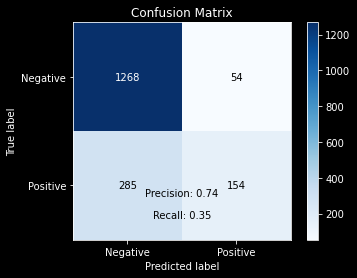

In [60]:
# Предсказанные метки на основе лучшего порога
best_predicted_labels = (y_pred_proba >= best_threshold).astype(int)

# Построение матрицы ошибок
cm = confusion_matrix(y_test, best_predicted_labels)

# Вычисление полноты и точности
precision = precision_score(y_test, best_predicted_labels)
recall = recall_score(y_test, best_predicted_labels)

# Визуализация матрицы ошибок
labels = ['Negative', 'Positive']
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Вставка значений в матрицу ошибок
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

# Вывод полноты и точности
plt.text(0.5, 0.2, f'Precision: {precision:.2f}', transform=plt.gca().transAxes, ha='center', color='black')
plt.text(0.5, 0.1, f'Recall: {recall:.2f}', transform=plt.gca().transAxes, ha='center', color='black')

plt.show()

Точность (`Precision`) высокая - `0.74`, что означает, что предсказанные договоры к закрытию действительно определены корректно.
При этом полнота (`Recall`) достаточно низкая - `0.35`, это значит, что модель может предсказать только часть клиентов с потенциальным закрытием договоров. Для повышения уровня качества в этом направлении применяется подбор подходящего порога. Однако в рамках данного проекта перед нами такая задача не стоит.

Рассмотрим все квадранты:
- `Negative-Negative`- данный показатель отражает количество клиентов (`1 268 шт`), которые были на тесте корректно определены моделью как те, что не уйдут.
- `Negative-Positive` - количество клиентов, предсказанные моделью как потенциальные к потере (`54 шт`), однако по факту на тестовой выборке таковыми не являются.
- `Positive-Negative` - модель не смогла найти `285 шт` клиентов, которые по факту относятся к потерянным.
- `Positive-Positive` - модель корректно нашла `154 шт` клиентов, которые потенциально могут закрыть договор.

### Важность признаков

Рассмотрим и визуализируем важность признаков выбранной модели.

,Признак,Значение
0,Type,18.560389
4,TotalCharges,14.075305
9,InternetService,8.643436
18,Term,6.579776
16,MultipleLines,5.916467
3,MonthlyCharges,5.805571
2,PaymentMethod,5.593064
10,OnlineSecurity,5.430464
11,OnlineBackup,4.388413
13,TechSupport,4.336215


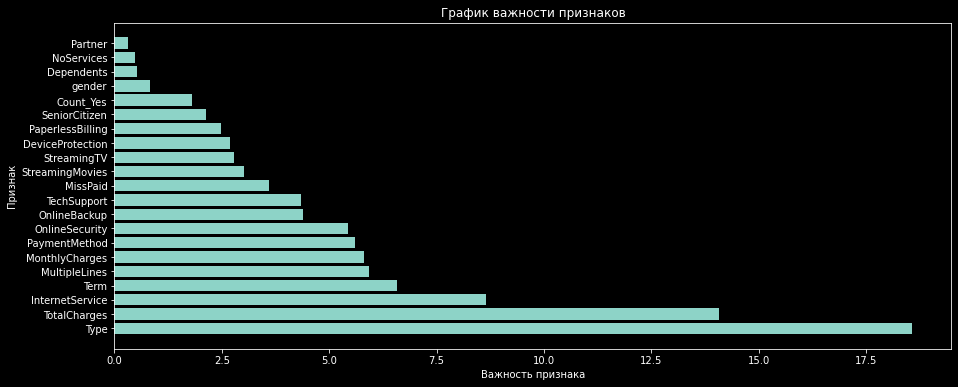

In [69]:
feature_importances = best_model.feature_importances_

feature_importances_df = pd.DataFrame({'Признак': X_train_splited.columns, 'Значение': feature_importances})
sorted_feature_importances_df = feature_importances_df.sort_values(by='Значение', ascending=False)
display(sorted_feature_importances_df)

# Визуализация важности признаков
plt.figure(figsize=(15, 6))

plt.barh(range(len(sorted_feature_importances_df)), sorted_feature_importances_df['Значение'])
plt.yticks(range(len(sorted_feature_importances_df)), sorted_feature_importances_df['Признак'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('График важности признаков')
plt.show()

Наиболее важными признаками для предсказания модели являются `Type` (тип оплаты: раз в год-два или ежемесячно) и `TotalCharges` (всего заплатил клиент).

### Зависимости входного и целевого признаков

Посмотрим доли оттока клиентов наиболее влияющего признака `Type` (тип оплаты: раз в год-два или ежемесячно).

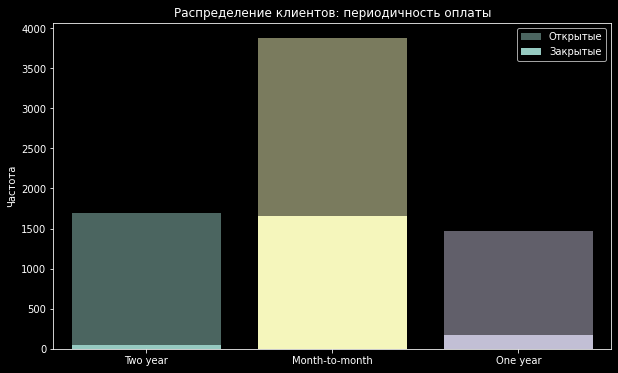

In [63]:
plt.figure(figsize=(10, 6))
type_order = merged_df['Type'].unique()
sns.countplot(data=merged_df, x='Type', order=type_order, alpha=0.5, label='Открытые')
sns.countplot(data=merged_df.loc[merged_df['Closed'] == 1], x='Type', order=type_order, label='Закрытые')
plt.title('Распределение клиентов: периодичность оплаты')
plt.ylabel('Частота')
plt.xlabel('')
plt.legend()
plt.show()

Мы визуализировали соотношение каждого вида оплаты и долю его оттока клиентов. Явно наблюдается тенденция к потере клиентов при ежемесячной оплате - `43%`, при этом данный тип является также самым часто используемым - `55%` от всех договоров.

Остальные вида оплаты встречаются реже, также можно заметить совершенно несущественный отток клиентов по ним.

## Вывод

По результатам работы было выполнено следующее:

1. Получены, проверены и проанализированны входные данные.
2. Проанализированы харастеристики пользователей, склонным к закрытию договоров, портрет потенциально потеренного клиента выглядит следующим образом:
- Ежемесячная оплата
- Электронный расчетный лист
- Тип платежа `Electronic check`
- Ежемесячные расходы `70-120 ед.`
- Любого пола
- Не относится к перисионному возрасту
- Вероятнее всего не имеет супруга
- Не имеет детей
- Тип подключения `Fiber optic`
- Блокировка опасных сайтов отсутствует
- Резервное копирование отсутствует
- Антивирус отсутствует
- Выделенная линия тех. поддержки не используется
- Стриминговое телевидение и каталог фильмов могут быть как подключены, так и не подключены
- Может иметь как одну, так и несколько линий
- Вероятнее всего пользуется не всеми услугами, но частью из них
- Договор был открыт в период `Октябрь 2019` - `Январь 2020`
- Стоимость ежемесячных платежей выше среднего по портфелю клиентов
- Срок жизни договора `200-400` дней
3. Категориальные данные были закодированы, признаки масштабированы, выборки разделены на тренировочную и тестовую.
4. Обучены модели: `Случайный лес`, бустинговая модель `CatBoost` и нейронная сеть на `PyTorch`. Были задействованы кросс-валидация и подбор гиперпараметров. По результатам заданной в задании метрики качества `Roc-AUC` была выбрана модель с лучшими результатами на валидации - бустинговая модель `CatBoost`.
5. На тестовой выборке метрика качества `Roc-AUC` показала `0.853` - поставленная задача выполнена, заданная метрика качества выше `0.85`.
6. Рассмотрены дополнительные метрики качества: `Accuracy` (`0.81`), `Precision` (`0.74`) и `Recall` (`0.35`).
7. Проанализированы матрица ошибок и важнсть признаков. Наиболее важными признаками для модели стали `Type` (тип оплаты: раз в год-два или ежемесячно) и `TotalCharges` (всего заплатил клиент).

По результатам проделанной работы мы можем дать бизнесу следующие рекомендации:
- Рассмотреть возможность перевода пользователей на ежегодные подписки.
- Перейти на оказание услуг по предоплате.
- Провести дополнительный анализ признаков по портрету потенциально потерянного клиента, внести необхдимые корректировки (возможно, акции/скидки на дополнительные услуги, дополнительный молодежный контент для ТВ, и т.д.).